<a href="https://colab.research.google.com/github/laaksonenl/machine-learning/blob/master/bank_marketing_decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank markerting classification with decision trees

**Goal:**

The main goal is to develop a predictive model which will tell if a client is open to create a term deposit based on the client's characteristics

**Hypothesis:**

The base hypothesis is that the wealthier, middle-aged people are the most potential customers in regards of the deposit.

**Data Set Information:**

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

There are four datasets:
1) bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
2) bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
3) bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs).
4) bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs).
The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM).

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

In [35]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip 
! unzip /content/bank.zip

--2020-09-21 14:28:09--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579043 (565K) [application/x-httpd-php]
Saving to: ‘bank.zip.1’

bank.zip.1          100%[===================>] 565.47K   872KB/s    in 0.6s    

2020-09-21 14:28:11 (872 KB/s) - ‘bank.zip.1’ saved [579043/579043]

Archive:  /content/bank.zip
replace bank-full.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: bank-full.csv           
replace bank-names.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace bank-names.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: bank-names.txt          
  inflating: bank.csv                


In [36]:
import pandas as pd

# Use the smaller dataset for now
df = pd.read_csv('/content/bank.csv', sep=';')

In [37]:
df_full = pd.read_csv('/content/bank-full.csv', sep=';')

In [38]:
print(df.shape)
print(df_full.shape)

(4521, 17)
(45211, 17)


## Exploratory analysis

In [39]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [40]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


### Numerical features

In [41]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


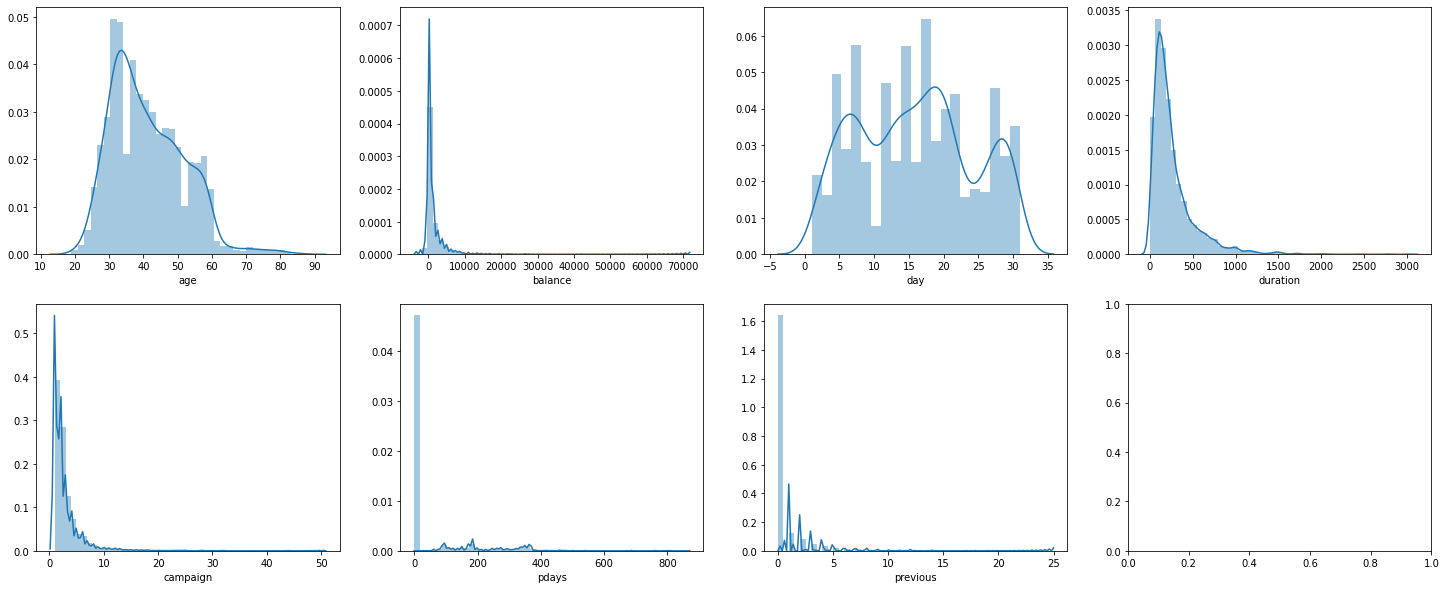

In [42]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_numericals(data, features):
  fig, axes = plt.subplots(2,4, figsize=(25,10))
  for ax, f in zip(axes.ravel(), features):
    sns.distplot(data[f], ax=ax)

numericals = df.select_dtypes([np.number]).columns
plot_numericals(df, numericals)

#### Age
Main focus has been on people with age between 30 and 40. Young people might not have that much extra cash and old people might not want to take term deposit, at least not for years forward.

#### Account balance (eur)
Most of the people have balance between 0 and 10 000 euros, although it goes from -30000 up to 70 000.

#### Last contact day of the month
Does not tell much, this is column should be analyzed with month feature which at this point is in categorical format (string values).
Days with less contacts might fall in weekends.

#### Phone call duration
On average calls took 4-5 minutes. There's much longer calls though. The longest reported call has taken 3000 seconds ( = 50 minutes).
Maybe there's correlation with phone duration and term deposits since bank needs to ask all kind of information for term deposit. Of course this depends on the bank's own practices.

#### Contacts during the campaign
Mostly only a few contacts per customer, the data does not tell us if all the contacts are about term deposit. It's hard to imagine situation where bank contacts over 10 times the same client about the same term deposit unless there's lots of confusion between these parties.

#### Number of days passed after the last contact of the previous campaign
Most of the clients were not part of the last campaign thus the peak at the start.

#### Number of contacts before this campaign
No previous or only a few were conducted for the most of the clients.

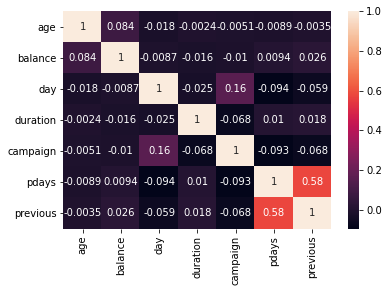

In [43]:
corr = df.corr()
sns.heatmap(corr, annot=True)

No strong correlations with numerical features except pdays and previous.

### Categorical features

In [44]:
categoricals = df.select_dtypes(['object'])
categoricals.head()

,job,marital,education,default,housing,loan,contact,month,poutcome,y
0,unemployed,married,primary,no,no,no,cellular,oct,unknown,no
1,services,married,secondary,no,yes,yes,cellular,may,failure,no
2,management,single,tertiary,no,yes,no,cellular,apr,failure,no
3,management,married,tertiary,no,yes,yes,unknown,jun,unknown,no
4,blue-collar,married,secondary,no,yes,no,unknown,may,unknown,no


In [45]:
def plot_categorical_count(ax, data, feature):
  plot = sns.countplot(data=data, x=feature, ax=ax)

  plot.set_xticklabels(
    plot.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'
  )

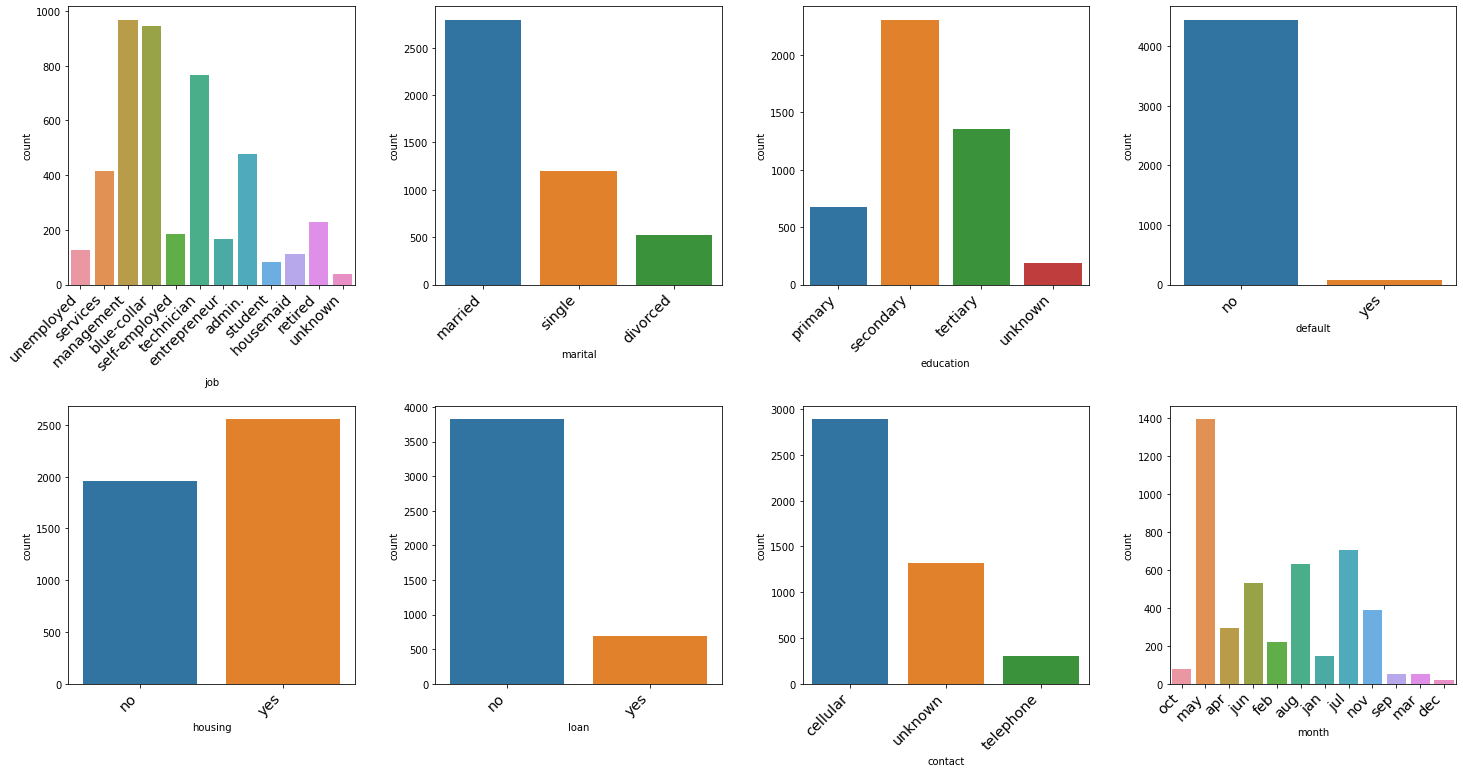

In [46]:
count = len(categoricals.columns)
fig, axes = plt.subplots(int(count / 4), 4, figsize=(20,10))
fig.tight_layout(w_pad=5.0, h_pad=10.0)

for ax, c in zip(axes.ravel(), categoricals):
  plot_categorical_count(ax, df, c)


- The campaign seems to focus on people with medium income, higher degree and without previous loans or defaults
- Interestingly enough, majority of the clients have no loan but own a house which means that the focus is on the wealthy people

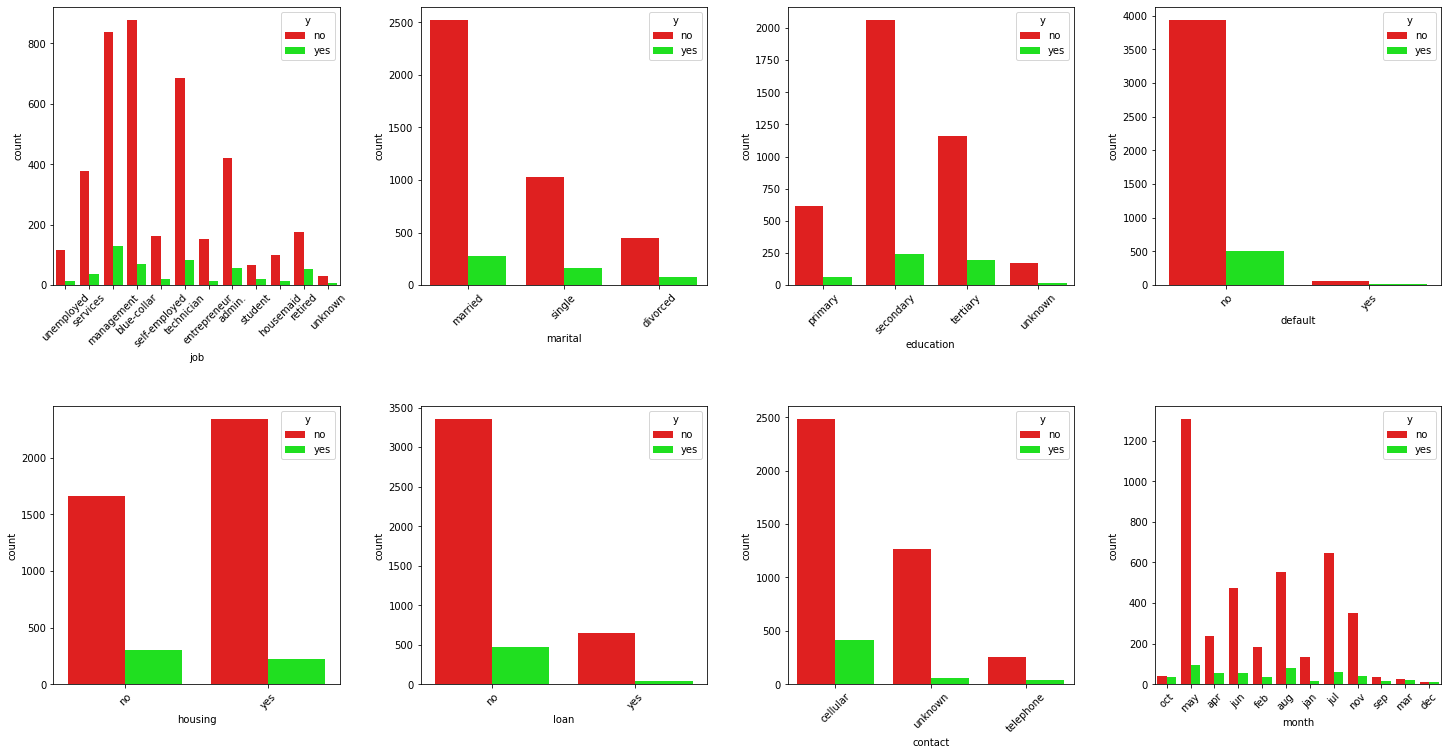

In [47]:
def plot_label_count(ax, data, feature):
  ax.tick_params(axis='x', labelrotation=45)
  sns.countplot(x=feature, hue='y', data=data, ax=ax, palette=['#FF0000',"#00FF00"])

count = len(categoricals.columns)
fig, axes = plt.subplots(int(count / 4), 4, figsize=(20,10))
fig.tight_layout(w_pad=5.0, h_pad=10.0)

for ax, c in zip(axes.ravel(), categoricals):
  plot_label_count(ax, df, c)

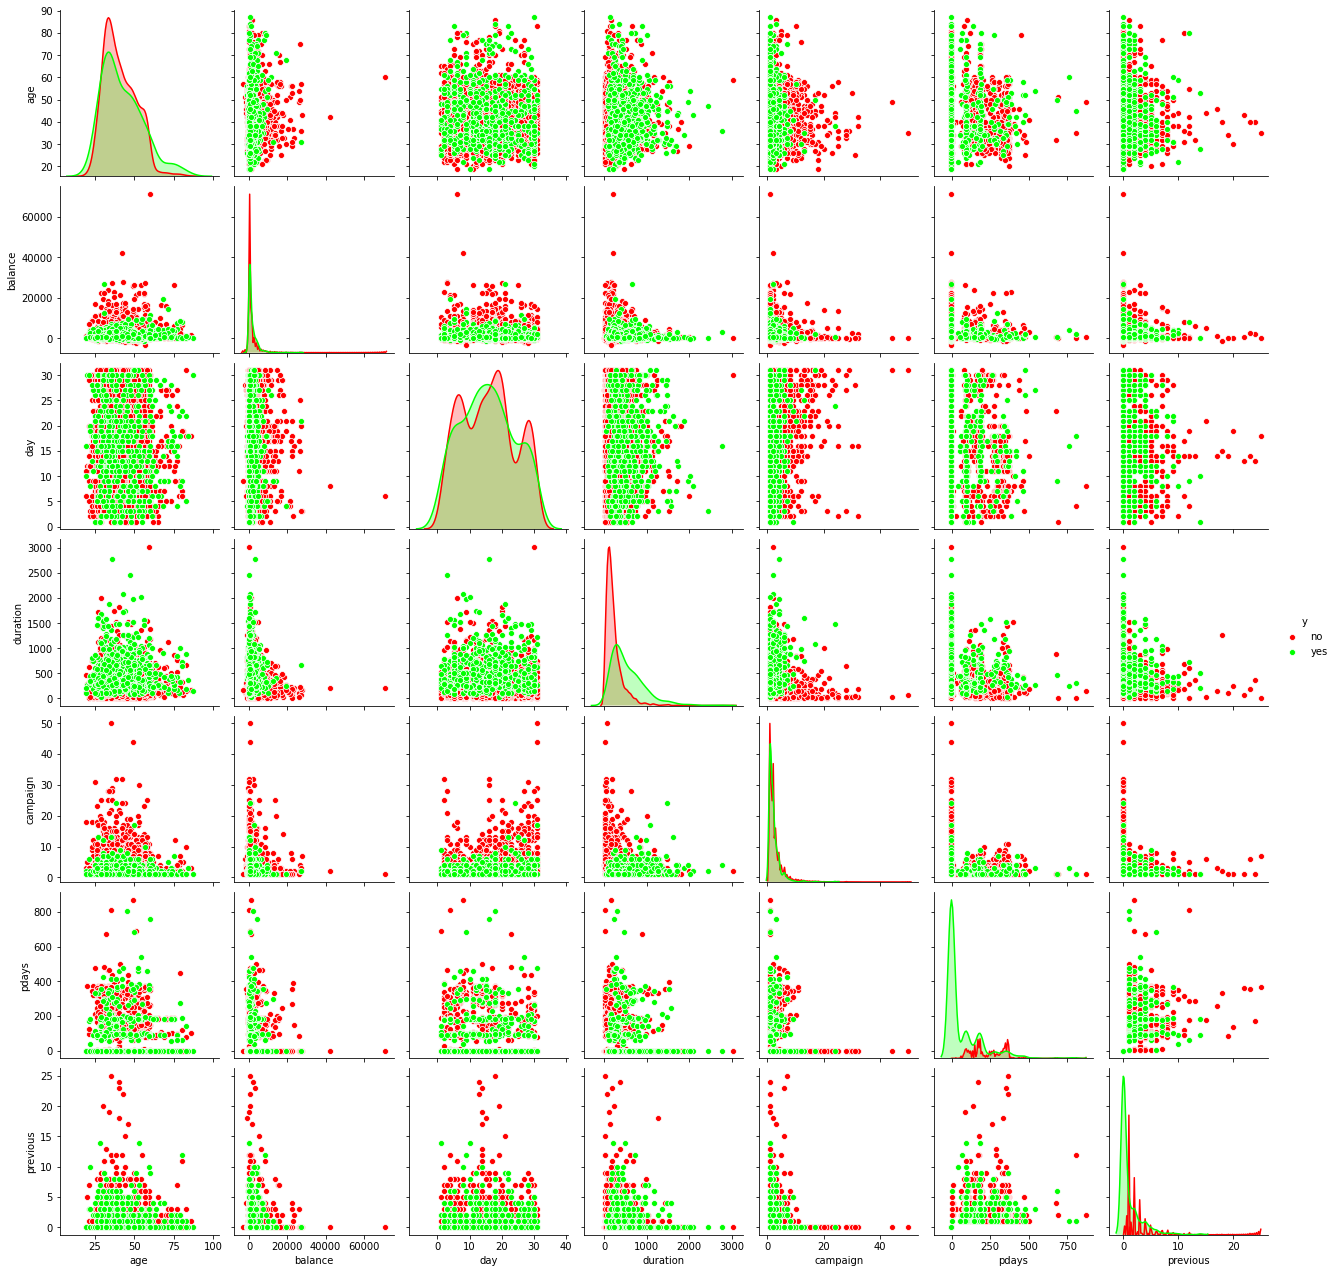

In [48]:
sns.pairplot(df, hue='y', palette=['#FF0000',"#00FF00"])

- Short calls tend to end up rejection
- The shorter the call and the more balance a client has, there's tendency reject the offer

In [84]:
from sklearn.preprocessing import LabelEncoder
# Convert label to numerical form
numlabel = df.copy()

le = LabelEncoder()
x = le.fit_transform(numlabel['y'])

numlabel['y'] = x

# Same as a one-liner
# numlabel['y'] = np.where(df['y'] == 'yes', 1, 0)

numlabel.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,0
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,0
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,0
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,0
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,0


In [50]:
label_corr = numlabel.corr()
label_corr['y'].sort_values(ascending=False)

y           1.000000
duration    0.401118
previous    0.116714
pdays       0.104087
age         0.045092
balance     0.017905
day        -0.011244
campaign   -0.061147
Name: y, dtype: float64

### Data preparation and cleaning

- No missing data so we don't have to impute any values


#### Outliers

[0]
[0]
[0]


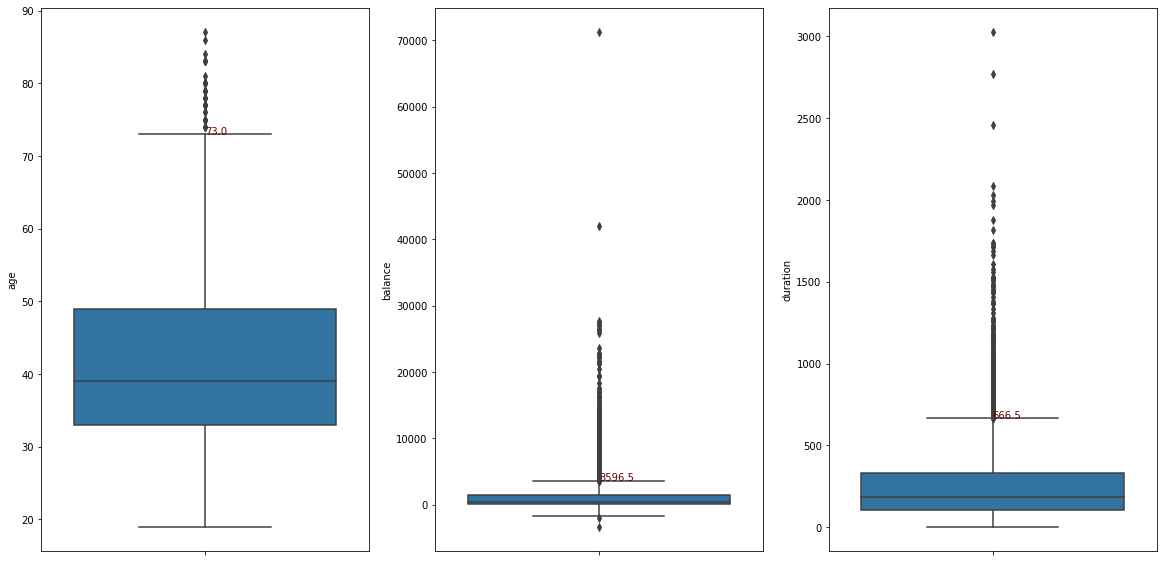

In [51]:

def calculate_outlier_bound(data):
  q1, q3 = np.percentile(data,[25,75])
  iqr = q3 - q1
  upper_bound = q3 +(1.5 * iqr) 
  return upper_bound

fig, axes = plt.subplots(1,3, figsize=(20,10))
features = ['age', 'balance', 'duration']
for ax, f in zip(axes, features):
  boxplot = sns.boxplot(y=f, data=numlabel, ax=ax)
  print(boxplot.get_xticks())
  upper_bound = calculate_outlier_bound(df[f])
  boxplot.text(x=0, y=upper_bound, s=str(upper_bound), color='#660000')

In [64]:
def remove_outliers(data, features):
  tmp = data.copy()
  for f in features:
    upper_limit = calculate_outlier_bound(data[f])
    outlier_idxs = tmp[tmp[f] > upper_limit].index
    tmp.drop(outlier_idxs, axis=0, inplace=True)
  return tmp

clean = remove_outliers(df, features)

In [65]:
clean.shape

(3700, 17)

### Encode categorical features

In [69]:
features = clean.drop('y', axis=1)
labels = clean['y']

clean[categoricals.columns].head()

,job,marital,education,default,housing,loan,contact,month,poutcome,y
0,unemployed,married,primary,no,no,no,cellular,oct,unknown,no
2,management,single,tertiary,no,yes,no,cellular,apr,failure,no
3,management,married,tertiary,no,yes,yes,unknown,jun,unknown,no
4,blue-collar,married,secondary,no,yes,no,unknown,may,unknown,no
5,management,single,tertiary,no,no,no,cellular,feb,failure,no


In [75]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

# With decision trees, it's not really necessary to scale features
# but let's do it for the sake of practice
num_pipeline = make_pipeline(StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder())

# Sklearn knows nothing about Pandas DataFrame, it accepts only numpy arrays
num_attribs = list(numericals)
cat_attribs = list(categoricals.drop('y', axis=1).columns)

# FeatureUnion applies different transformers to the WHOLE of the input data
# ColumnTransformer applies different transformers to different SUBSETS of the whole input data
full_pipeline = ColumnTransformer([
        ("numerical", num_pipeline, num_attribs),
        ("categorical", cat_pipeline, cat_attribs)
    ])

# Runs both num and cat pipelines in parallel
prepared = full_pipeline.fit_transform(features)